# Prova Intermediária - Machine Learning

**Nome do aluno**: <font color='red'>Luca Mizrahi</font>

Você deve submeter o trabalho via Blackboard. É de sua responsabilidade garantir que o arquivo correto foi enviado.

Se você precisou adicionar arquivos extras à essa prova, assegure-se de que você os está enviando também.

A prova é individual e com consulta. Faça o seu trabalho de maneira ética! Se você recebeu ajuda de sistemas de apoio inteligentes (por exemplo, ChatGPT, Bard, CoPilot, etc) DECLARE CLARAMENTE ONDE VOCÊ RECEBEU AJUDA para não configurar plágio (definido como "declarar como próprio o trabalho construido por outrem - neste caso um sistema computacional")

São 10 questões, cada uma valendo 1 ponto.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)

# Contexto do problema

Vamos trabalhar com um *dataset* de processadores antigos, da década de 1980! Nesses tempos o *hardware* era muito mais simples que nos dias atuais. O *dataset* possui atributos referentes ao *hardware* de diferentes máquinas, e o *target* é uma métrica de desempenho computacional relativo (relativo a qual valor-base? Honestamente, não sei, mas paciência).

Aqui está a documentação original do *dataset*:


```
1. Title: Relative CPU Performance Data 

2. Source Information
   -- Creators: Phillip Ein-Dor and Jacob Feldmesser
     -- Ein-Dor: Faculty of Management; Tel Aviv University; Ramat-Aviv; 
        Tel Aviv, 69978; Israel
   -- Donor: David W. Aha (aha@ics.uci.edu) (714) 856-8779   
   -- Date: October, 1987
 
3. Past Usage:
    1. Ein-Dor and Feldmesser (CACM 4/87, pp 308-317)
       -- Results: 
          -- linear regression prediction of relative cpu performance
          -- Recorded 34% average deviation from actual values 
    2. Kibler,D. & Aha,D. (1988).  Instance-Based Prediction of
       Real-Valued Attributes.  In Proceedings of the CSCSI (Canadian
       AI) Conference.
       -- Results:
          -- instance-based prediction of relative cpu performance
          -- similar results; no transformations required
    - Predicted attribute: cpu relative performance (numeric)

4. Relevant Information:
   -- The estimated relative performance values were estimated by the authors
      using a linear regression method.  See their article (pp 308-313) for
      more details on how the relative performance values were set.

5. Number of Instances: 209 

6. Number of Attributes: 10 (6 predictive attributes, 2 non-predictive, 
                             1 goal field, and the linear regression's guess)

7. Attribute Information:
   1. vendor name: 30 
      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, 
       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, 
       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, 
       sratus, wang)
   2. Model Name: many unique symbols
   3. MYCT: machine cycle time in nanoseconds (integer)
   4. MMIN: minimum main memory in kilobytes (integer)
   5. MMAX: maximum main memory in kilobytes (integer)
   6. CACH: cache memory in kilobytes (integer)
   7. CHMIN: minimum channels in units (integer)
   8. CHMAX: maximum channels in units (integer)
   9. PRP: published relative performance (integer)
  10. ERP: estimated relative performance from the original article (integer)

8. Missing Attribute Values: None

9. Class Distribution: the class value (PRP) is continuously valued.
   PRP Value Range:   Number of Instances in Range:
   0-20               31
   21-100             121
   101-200            27
   201-300            13
   301-400            7
   401-500            4
   501-600            2
   above 600          4

Summary Statistics:
	   Min  Max   Mean    SD      PRP Correlation
   MCYT:   17   1500  203.8   260.3   -0.3071
   MMIN:   64   32000 2868.0  3878.7   0.7949
   MMAX:   64   64000 11796.1 11726.6  0.8630
   CACH:   0    256   25.2    40.6     0.6626
   CHMIN:  0    52    4.7     6.8      0.6089
   CHMAX:  0    176   18.2    26.0     0.6052
   PRP:    6    1150  105.6   160.8    1.0000
   ERP:   15    1238  99.3    154.8    0.9665

```

Para melhor entender este *dataset*, segue uma explicação de cada atributo:

- `vendor name`: Nome do fabricante do processador.
- `Model Name`: Nome do modelo do processador.
- `MYCT`: Duração do ciclo de *clock* deste processador, em nanossegundos. Nesta época as frequências de trabalho das CPUs eram medidas em kHz ou MHz, e portando as durações de ciclo eram da ordem de magnitude de centenas de nanossegundos.
- `MMIN`, `MMAX`: Faixa de variação permitida para a quantidade de memória RAM aceita por esse processador.
- `CACH`: Tamanho da memória *cache* deste processador. Note que alguns processadores nem tinham memória *cache*.
- `CHMIN`, `CHMAX`: Faixa de valores de quantidade de canais de comunicação deste processador com periféricos.
- `PRP`: Performance relativa. <font color="red">Este é o *target*</font>
- `ERP`: Performance estimada pelos autores do artigo citado acima - <font color="red">Não deve ser usado como *feature*!</font>


# Análise exploratória

## Lendo o dataset

In [3]:
column_names = [
    'Vendor',
    'Model',
    'MYCT',
    'MMIN',
    'MMAX',
    'CACH',
    'CHMIN',
    'CHMAX',
    'PRP',
    'ERP',
]

df = pd.read_csv('machine.data', names=column_names)


In [4]:
df.shape

(209, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Vendor  209 non-null    object
 1   Model   209 non-null    object
 2   MYCT    209 non-null    int64 
 3   MMIN    209 non-null    int64 
 4   MMAX    209 non-null    int64 
 5   CACH    209 non-null    int64 
 6   CHMIN   209 non-null    int64 
 7   CHMAX   209 non-null    int64 
 8   PRP     209 non-null    int64 
 9   ERP     209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB


In [6]:
from sklearn.utils import shuffle

df = shuffle(df)
df

,Vendor,Model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
30,cdc,cyber:170/750,25,1310,2620,131,12,24,274,102
171,nixdorf,8890/50,200,1000,4000,0,1,4,30,25
84,honeywell,dps:7/45,330,1000,4000,0,3,6,22,25
198,sperry,1100/93,30,8000,64000,96,12,176,915,919
60,formation,f4000/300,800,256,8000,0,1,4,16,34
...,...,...,...,...,...,...,...,...,...,...
106,ibm,38/8,400,4000,8000,0,1,1,32,45
14,bti,5000,350,64,64,0,1,4,10,15
92,honeywell,dps:8/20,140,2000,4000,8,1,20,22,32
179,prime,50-750-ii,160,1000,8000,16,1,14,60,43


## Preparação inicial do *dataset*

### `Vendor`

In [7]:
vendor_counts = df['Vendor'].value_counts()
vendor_counts


Vendor
ibm             32
nas             19
honeywell       13
sperry          13
ncr             13
siemens         12
cdc              9
amdahl           9
burroughs        8
hp               7
dg               7
harris           7
dec              6
c.r.d            6
magnuson         6
ipl              6
formation        5
prime            5
cambex           5
nixdorf          3
gould            3
perkin-elmer     3
bti              2
wang             2
basf             2
apollo           2
sratus           1
four-phase       1
adviser          1
microdata        1
Name: count, dtype: int64

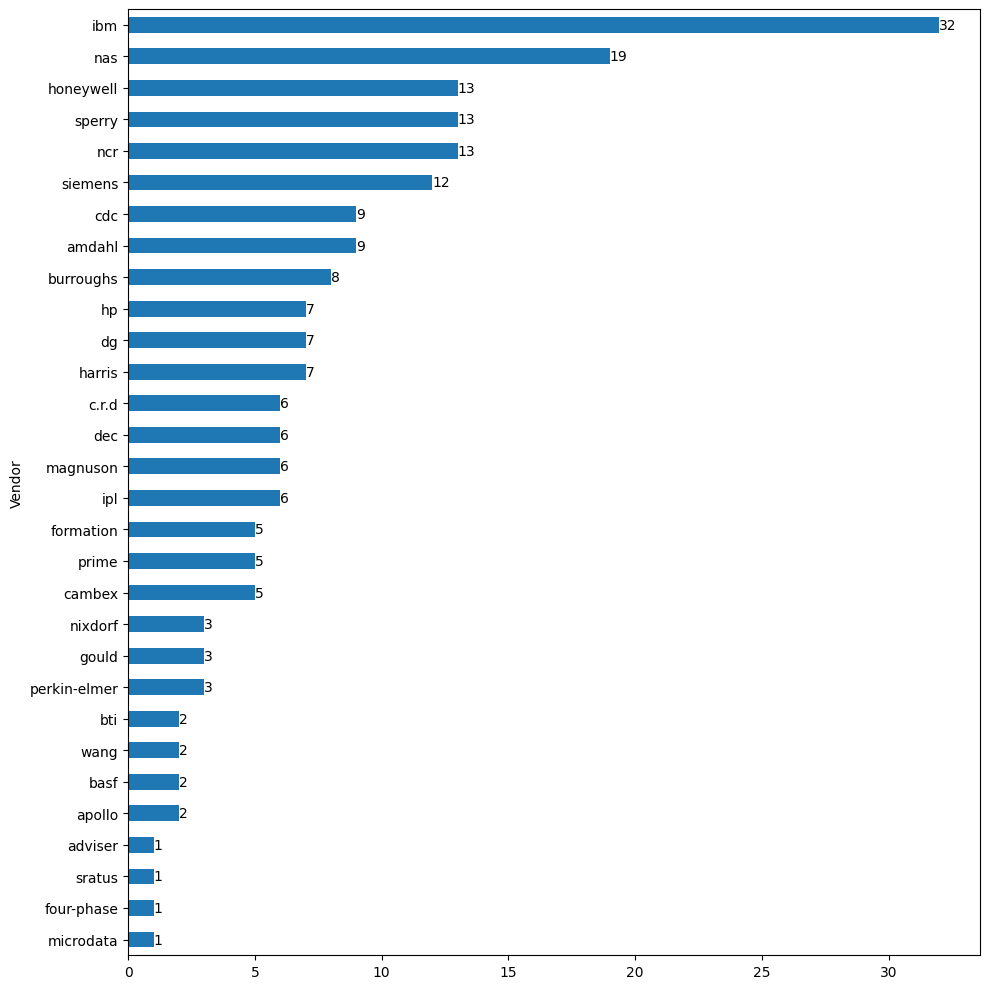

In [8]:
ax = vendor_counts \
    .sort_values(ascending=True) \
    .plot \
    .barh(figsize=(10, 10))
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

Tem muitos fabricantes com poucos modelos de CPU. Vamos agrupá-los em uma categoria `others`:

In [9]:
small_vendors = list(vendor_counts[vendor_counts <= 10].index)
small_vendors

['cdc',
 'amdahl',
 'burroughs',
 'hp',
 'dg',
 'harris',
 'dec',
 'c.r.d',
 'magnuson',
 'ipl',
 'formation',
 'prime',
 'cambex',
 'nixdorf',
 'gould',
 'perkin-elmer',
 'bti',
 'wang',
 'basf',
 'apollo',
 'sratus',
 'four-phase',
 'adviser',
 'microdata']

In [10]:
df.loc[df['Vendor'].isin(small_vendors), 'Vendor'] = 'others'

In [11]:
vendor_counts = df['Vendor'].value_counts()
vendor_counts


Vendor
others       107
ibm           32
nas           19
honeywell     13
sperry        13
ncr           13
siemens       12
Name: count, dtype: int64

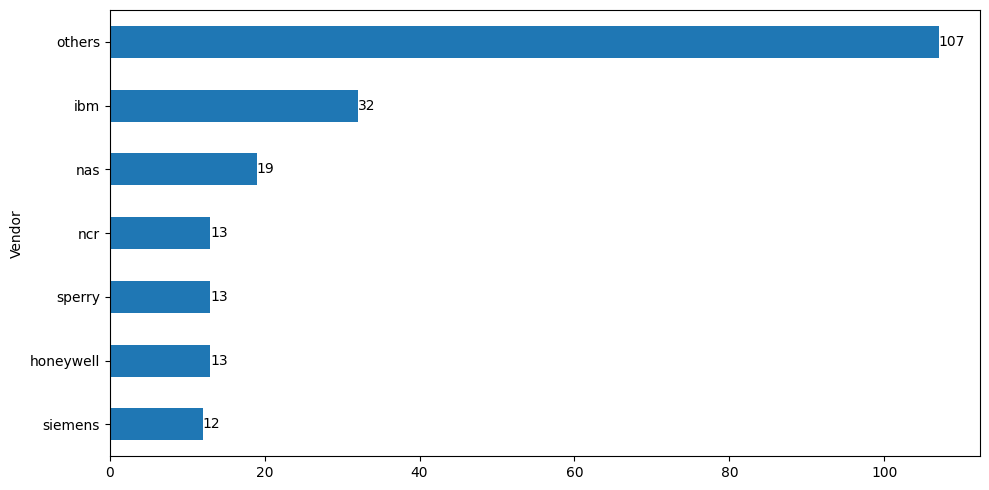

In [12]:
ax = vendor_counts \
    .sort_values(ascending=True) \
    .plot \
    .barh(figsize=(10, 5))
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()


In [13]:
df['Vendor'] = df['Vendor'].astype('category')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 30 to 102
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Vendor  209 non-null    category
 1   Model   209 non-null    object  
 2   MYCT    209 non-null    int64   
 3   MMIN    209 non-null    int64   
 4   MMAX    209 non-null    int64   
 5   CACH    209 non-null    int64   
 6   CHMIN   209 non-null    int64   
 7   CHMAX   209 non-null    int64   
 8   PRP     209 non-null    int64   
 9   ERP     209 non-null    int64   
dtypes: category(1), int64(8), object(1)
memory usage: 16.9+ KB


### `Model`

O nome do modelo não significa nada, vamos descartar essa coluna:

In [15]:
df = df.drop(columns=['Model'])

## Estatísticas descritivas simples e visualizações

As estatísticas descritivas simples (contagens, médias, medianas, desvios, etc.) são a primeira verificação do dataset, para que tenhamos uma noção da natureza dos dados. Tendo esse entendimento inicial, teremos melhor capacidade de conceber boas visualizações dos dados para continuar a ampliar nosso entendimento da situação.

Estatísticas descritivas das variáveis contínuas
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%     

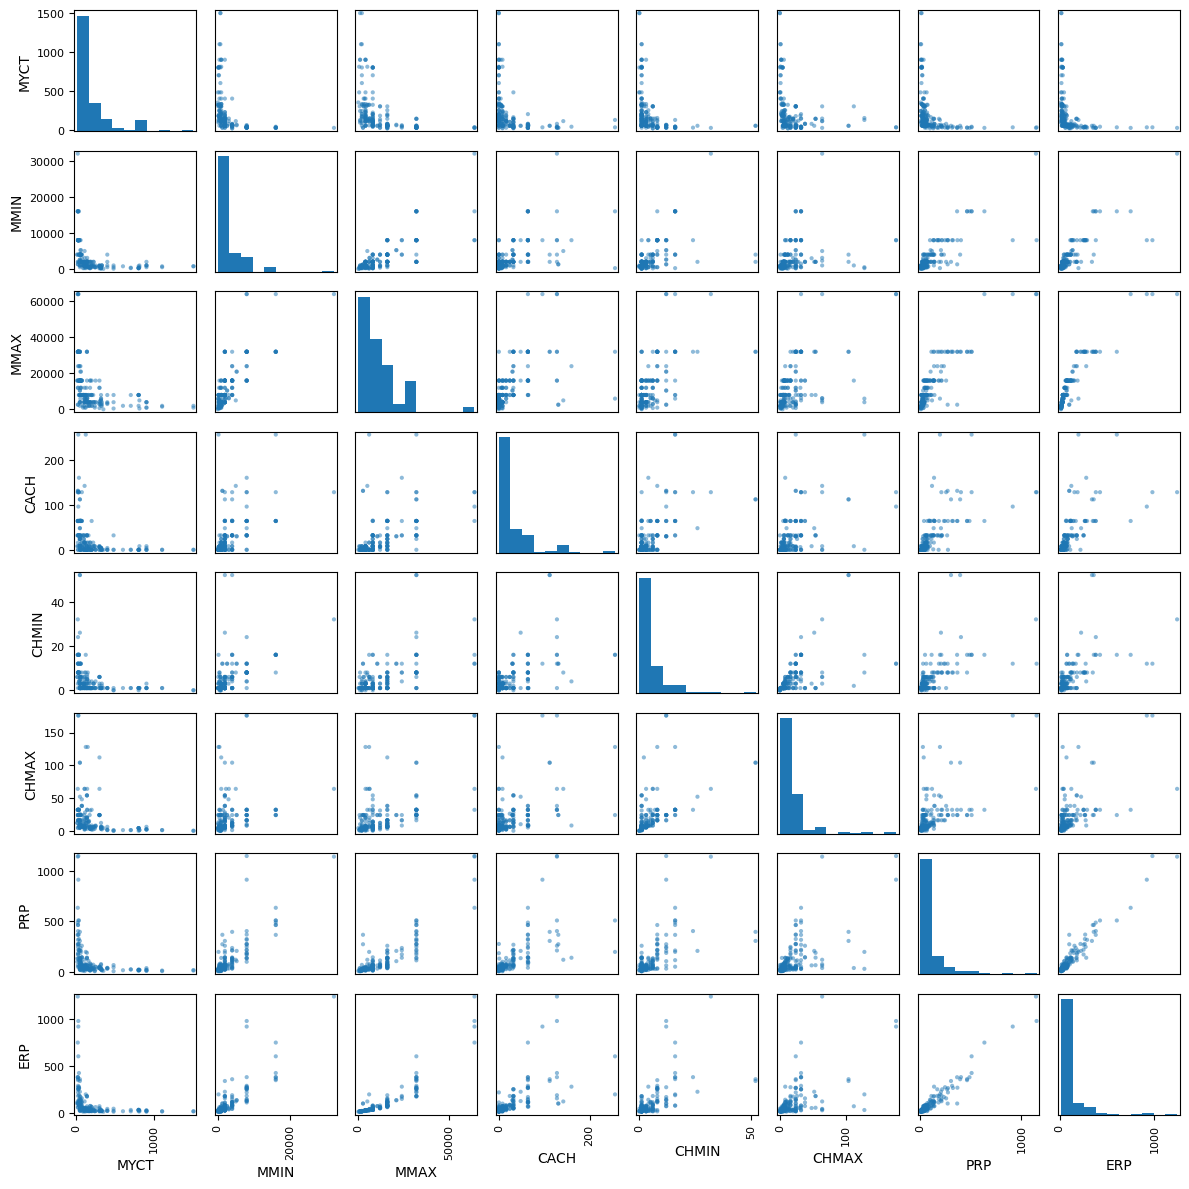

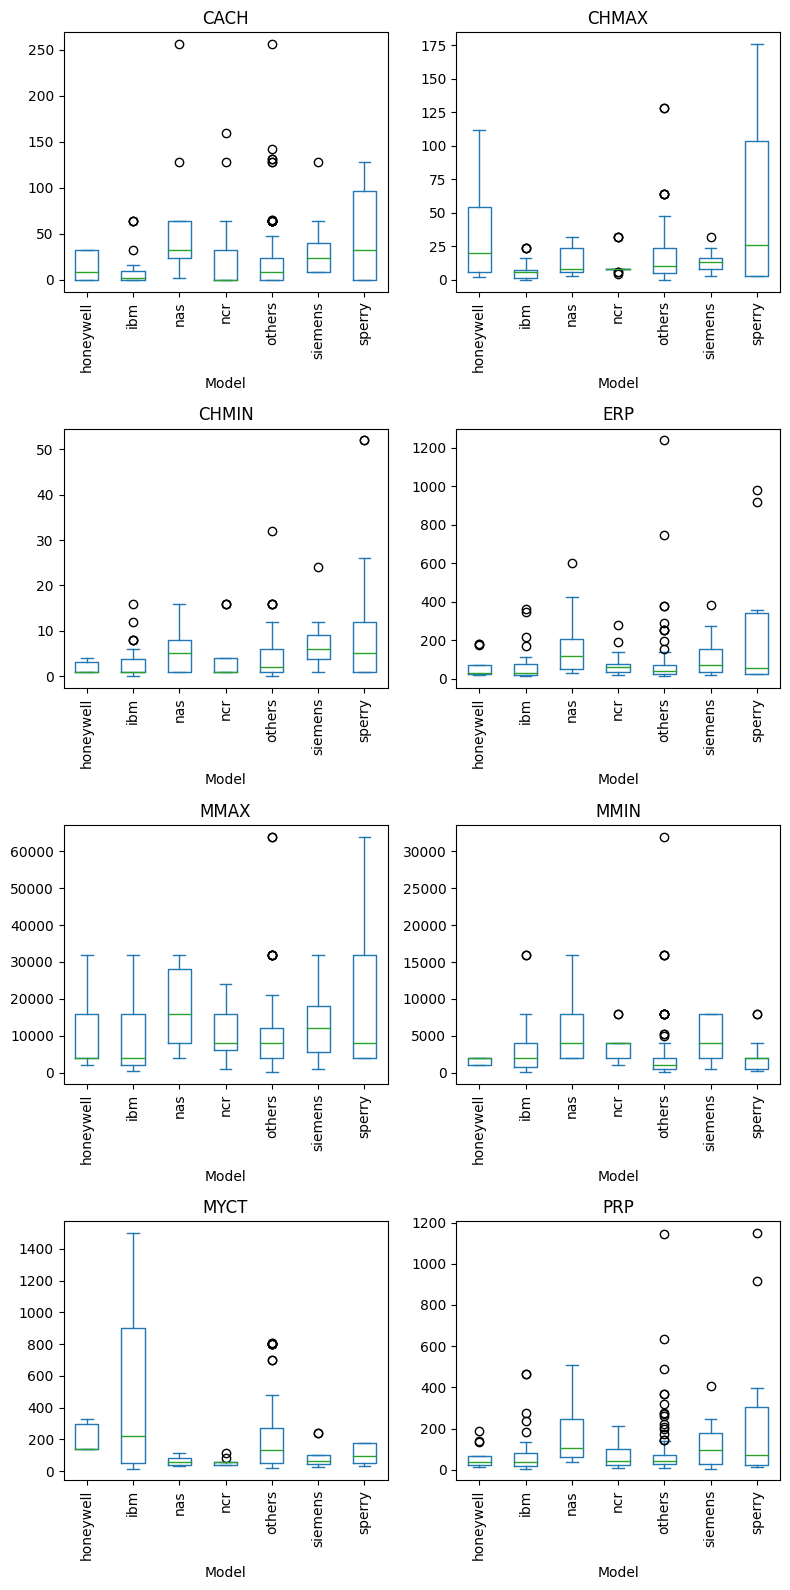

In [16]:
import warnings


def visualize(df):
    print('Estatísticas descritivas das variáveis contínuas')
    print(df.describe(include=np.number))
    print()

    print('Estatísticas descritivas das variáveis categóricas')
    print(df.describe(include='category'))
    print()

    df_train_numericals = df.select_dtypes(np.number)

    print('Correlações entre as variáveis numéricas')
    print(df_train_numericals.corr())
    print()

    print('Visualizações')

    pd.plotting.scatter_matrix(df_train_numericals, figsize=(12, 12))
    plt.tight_layout()
    plt.show()

    with warnings.catch_warnings(action='ignore', category=FutureWarning):
        df.plot.box(
            by='Vendor',
            layout=(4, 2),
            figsize=(8, 16),
            xlabel='Model',
            rot=90,
        )
    plt.tight_layout()
    plt.show()


visualize(df)


## One-hot-encoding, e separando *features* e *target*

Lembre-se que a coluna `ERP` não é nem *feature*, nem *target*: trata-se dos valores preditos de desempenho conforme descrito no artigo dos autores do *dataset*. Não vamos usar essa coluna no modelo.

In [17]:
df = pd.get_dummies(df)
df.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP,Vendor_honeywell,Vendor_ibm,Vendor_nas,Vendor_ncr,Vendor_others,Vendor_siemens,Vendor_sperry
30,25,1310,2620,131,12,24,274,102,False,False,False,False,True,False,False
171,200,1000,4000,0,1,4,30,25,False,False,False,False,True,False,False
84,330,1000,4000,0,3,6,22,25,True,False,False,False,False,False,False
198,30,8000,64000,96,12,176,915,919,False,False,False,False,False,False,True
60,800,256,8000,0,1,4,16,34,False,False,False,False,True,False,False


In [18]:
X = df.drop(columns=['PRP', 'ERP', 'Vendor_others']).copy()
y = df['PRP'].copy()

In [19]:
X.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Vendor_honeywell,Vendor_ibm,Vendor_nas,Vendor_ncr,Vendor_siemens,Vendor_sperry
30,25,1310,2620,131,12,24,False,False,False,False,False,False
171,200,1000,4000,0,1,4,False,False,False,False,False,False
84,330,1000,4000,0,3,6,True,False,False,False,False,False
198,30,8000,64000,96,12,176,False,False,False,False,False,True
60,800,256,8000,0,1,4,False,False,False,False,False,False


In [20]:
y.head()

30     274
171     30
84      22
198    915
60      16
Name: PRP, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
X_train.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Vendor_honeywell,Vendor_ibm,Vendor_nas,Vendor_ncr,Vendor_siemens,Vendor_sperry
4,29,8000,16000,32,8,16,False,False,False,False,False,False
15,200,512,16000,0,4,32,False,False,False,False,False,False
98,26,8000,16000,0,8,16,False,True,False,False,False,False
186,52,4000,16000,32,4,12,False,False,False,False,True,False
126,50,2000,8000,8,3,6,False,False,False,False,False,False


In [23]:
y_train.head()

4      132
15      35
98     185
186    130
126     45
Name: PRP, dtype: int64

# Prova intermediária

## Parte prática

Ao longo das questões seguintes você vai construir um projeto de regressão.

**Questão 1**: Analise o desempenho RMSE de um modelo de regressão linear para estes dados usando validação cruzada com 5 partições.Dica: use a métricDica: use a métrica `"neg_mean_squared_error"` no argumento `scoring` da função `cross_val_score`, e corrija adequadamente os escores obtidos.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = LinearRegression()

result = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rmse_scores = np.sqrt(-result)
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

mean_rmse, std_rmse

(69.90647582114474, 14.82648330500017)

**Questão 2**: Construa uma função que recebe a tabela de *features* (i.e. `X_train` ou `X_test`) e retorna os dados com *feature engineering* conforme descrito a seguir:

- Primeiro transforme a coluna `MYCT`: aplique uma transformação do tipo $f(x) = 1 / x$.
- Normalize (`StandardScaler` no scikit-learn) **apenas as colunas** `MYCT` (transformada), `MMIN`, `MMAX`, `CACH`, `CHMIN`, `CHMAX`.
- Depois, construa *features* polinomiais (`PolynomialFeatures` no scikit-learn) de grau 2 **apenas para as colunas** `MYCT` (transformada), `MMIN`, `MMAX`, `CACH`, `CHMIN`, `CHMAX`.

Não é obrigatório o uso de `Pipeline` ou `ColumnTransformer` - esteja livre para usá-los ou não, conforme preferir.

Aplique esta função para processar os dados de treinamento.

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 4 to 87
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   MYCT              167 non-null    int64
 1   MMIN              167 non-null    int64
 2   MMAX              167 non-null    int64
 3   CACH              167 non-null    int64
 4   CHMIN             167 non-null    int64
 5   CHMAX             167 non-null    int64
 6   Vendor_honeywell  167 non-null    bool 
 7   Vendor_ibm        167 non-null    bool 
 8   Vendor_nas        167 non-null    bool 
 9   Vendor_ncr        167 non-null    bool 
 10  Vendor_siemens    167 non-null    bool 
 11  Vendor_sperry     167 non-null    bool 
dtypes: bool(6), int64(6)
memory usage: 10.1 KB


In [46]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np

def process_features(X):
    # Transformação da coluna MYCT
    X_transformed = X.copy()
    X_transformed['MYCT'] = 1 / X_transformed['MYCT']
    
    # Normalizando as colunas especificadas
    columns_to_scale = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
    scaler = StandardScaler()
    X_transformed[columns_to_scale] = scaler.fit_transform(X_transformed[columns_to_scale])
    
    # Construindo features polinomiais de grau 2 para as colunas especificadas
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_transformed[columns_to_scale])
    
    # Criando um DataFrame para as features polinomiais
    poly_features_names = poly.get_feature_names_out(columns_to_scale)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_features_names)

    # Incluindo outras colunas que não passaram por feature engineering
    for col in X_transformed.columns:
        if col not in columns_to_scale:
            X_poly_df[col] = X_transformed[col].values
    
    return X_poly_df

X_train_processed = process_features(X_train)
X_train_processed.head()


,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,MYCT^2,MYCT MMIN,MYCT MMAX,MYCT CACH,...,CACH CHMAX,CHMIN^2,CHMIN CHMAX,CHMAX^2,Vendor_honeywell,Vendor_ibm,Vendor_nas,Vendor_ncr,Vendor_siemens,Vendor_sperry
0,1.657572,1.294478,0.388868,0.159203,0.770300,-0.067169,2.747546,2.145690,0.644577,0.263891,...,-0.010693,0.593362,-0.051740,0.004512,False,False,False,False,False,False
1,-0.708269,-0.602467,0.388868,-0.612831,-0.055640,0.539165,0.501644,0.426709,-0.275423,0.434049,...,-0.330417,0.003096,-0.029999,0.290699,False,False,False,False,False,False
2,1.976849,1.294478,0.388868,-0.612831,0.770300,-0.067169,3.907932,2.558987,0.768734,-1.211475,...,0.041163,0.593362,-0.051740,0.004512,False,True,False,False,False,False
3,0.433678,0.281152,0.388868,0.159203,-0.055640,-0.218752,0.188077,0.121930,0.168644,0.069043,...,-0.034826,0.003096,0.012171,0.047853,False,False,False,False,True,False
4,0.495405,-0.225510,-0.282874,-0.419823,-0.262125,-0.446128,0.245426,-0.111719,-0.140137,-0.207982,...,0.187294,0.068709,0.116941,0.199030,False,False,False,False,False,False


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
import numpy as np

def build_preprocessing_pipeline():
    # Definindo a transformação para a coluna MYCT
    transform_myct = FunctionTransformer(lambda x: 1/x, validate=True)
    
    # Definindo a pipeline para as colunas que serão normalizadas e terão features polinomiais
    numeric_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
    
    numeric_transformer = Pipeline(steps=[
        ('transform_myct', ColumnTransformer([
            ('myct_transform', transform_myct, ['MYCT']),
            ('pass', 'passthrough', numeric_features[1:])
        ])),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ])
    
    # # Compondo o processamento final com ColumnTransformer
    # # Aqui, assumimos que todas as outras colunas que não são listadas serão passadas como estão
    # preprocessor = ColumnTransformer(
    #     transformers=[
    #         ('num', numeric_transformer, numeric_features)
    #     ],
    #     remainder='passthrough' # Especifica que as colunas não listadas devem ser mantidas como estão
    # )
    
    return numeric_transformer

# Para aplicar a pipeline de pré-processamento
pipeline = build_preprocessing_pipeline()
X_train_processed = pipeline.fit_transform(X_train)
X_train_processed

array([[ 1.6575722 ,  1.29447775,  0.38886827, ...,  0.59336236,
        -0.0517401 ,  0.00451164],
       [-0.70826851, -0.60246749,  0.38886827, ...,  0.00309577,
        -0.02999898,  0.29069925],
       [ 1.97684895,  1.29447775,  0.38886827, ...,  0.59336236,
        -0.0517401 ,  0.00451164],
       ...,
       [ 2.10030262, -0.40030906, -0.73462036, ...,  2.54798217,
         0.37670992,  0.05569519],
       [-0.53631518, -0.22551042, -0.28287381, ...,  0.45575263,
        -0.9268202 ,  1.88478489],
       [-0.53631518, -0.22551042, -0.61874485, ...,  0.45575263,
        -0.05698795,  0.00712585]])

In [48]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer

def process_data(X):

    X = X.copy()

    columns_to_process = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']

    X["MYCT"] = 1 / X["MYCT"]

    # Full pipeline
    full_pipeline = ColumnTransformer([
        ('std', StandardScaler(), columns_to_process),
        ('poly', PolynomialFeatures(degree=2), columns_to_process)
    ])

    return full_pipeline.fit_transform(X)

X_train_processed = process_data(X_train)
X_train_processed

array([[ 1.65757220e+00,  1.29447775e+00,  3.88868273e-01, ...,
         6.40000000e+01,  1.28000000e+02,  2.56000000e+02],
       [-7.08268514e-01, -6.02467489e-01,  3.88868273e-01, ...,
         1.60000000e+01,  1.28000000e+02,  1.02400000e+03],
       [ 1.97684895e+00,  1.29447775e+00,  3.88868273e-01, ...,
         6.40000000e+01,  1.28000000e+02,  2.56000000e+02],
       ...,
       [ 2.10030262e+00, -4.00309061e-01, -7.34620359e-01, ...,
         1.44000000e+02,  2.88000000e+02,  5.76000000e+02],
       [-5.36315179e-01, -2.25510421e-01, -2.82873809e-01, ...,
         1.00000000e+00,  5.40000000e+01,  2.91600000e+03],
       [-5.36315179e-01, -2.25510421e-01, -6.18744850e-01, ...,
         1.00000000e+00,  2.00000000e+01,  4.00000000e+02]])

**Questão 3**: Analise o desempenho RMSE de um modelo de regressão linear para estes novos dados usando validação cruzada com 5 partições.

In [49]:
model2 = LinearRegression()

result2 = cross_val_score(
    model2,
    X_train_processed,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rmse_scores2 = np.sqrt(-result2)
mean_rmse2 = np.mean(rmse_scores2)
std_rmse2 = np.std(rmse_scores2)

mean_rmse2, std_rmse2

(85.27047712580239, 34.809701159696026)

**Questão 4**: Compare os dois modelos investigados nas questões anteriores. Existe evidência de que o modelo mais complexo é melhor que o modelo simples?

In [30]:
from scipy.stats import ttest_ind

ttest_ind(result, result2, equal_var=True)

Ttest_indResult(statistic=1.0422338380651308, pvalue=0.32777262391556533)

Dado que o p_valor > 0.05, não é possível afirmar, com significância estatística que o modelo mais complexo é melhor que o modelo mais simples, já que os modelos não apresentam desempenhos médios diferentes.

**Questão 5**: Retreine o modelo escolhido (se não houver evidencia de superioridade de um modelo sobre o outro, escolha o que você quiser) no conjunto de treinamento completo e meça o desempenho final no conjunto de teste. (O modelo continua sendo uma regressão linear, o que muda é o uso do conjunto de treinamento original ou o com *feature engineering*)

In [31]:
# Dado que o modelo de regressão linear com os dados originais teve um RMSE menor, vou optar por usá-lo

model.fit(X_train, y_train)
y_pred_final = model.predict(X_test)
y_pred_final

array([ 54.57115346,  78.12344062,  22.61009425,  -6.57552324,
       463.0777312 , 313.32347332,  96.68482921,   5.47263973,
       483.9520809 ,  72.28977795, 378.82797808, 548.38816161,
       105.05700411, -12.55426885,  86.24258456, -47.32614156,
       575.00817805, -17.13934931, 115.82772358, 318.429126  ,
        61.15205177,  27.72762337,  -3.37516783, 175.98044605,
        53.20338003, 310.56344068, 191.12843631,  65.20198461,
        36.0928139 ,  27.04871342, 108.41741452,  69.07431835,
        86.24258456, -18.39364111,  88.09289758,  70.31150602,
        84.95019139,  63.89442506,  21.33043263,  -7.04825077,
         5.10676546, -15.64565777])

**Questão 6**: Compare o desempenho do seu modelo preditivo com o desempenho do modelo preditivo dos autores do *dataset*, de acordo com as predições vistas na coluna `ERP`. 

In [32]:
# Resultado do Modelo Preditivo
from sklearn.metrics import mean_squared_error

final_result = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_result

66.49362750099102

In [36]:
# Resultado do Modelo dos Autores do Dataset (Coluna ERP)

autores_final_result = np.sqrt(mean_squared_error(df['PRP'], df['ERP']))
autores_final_result

41.68134988492653

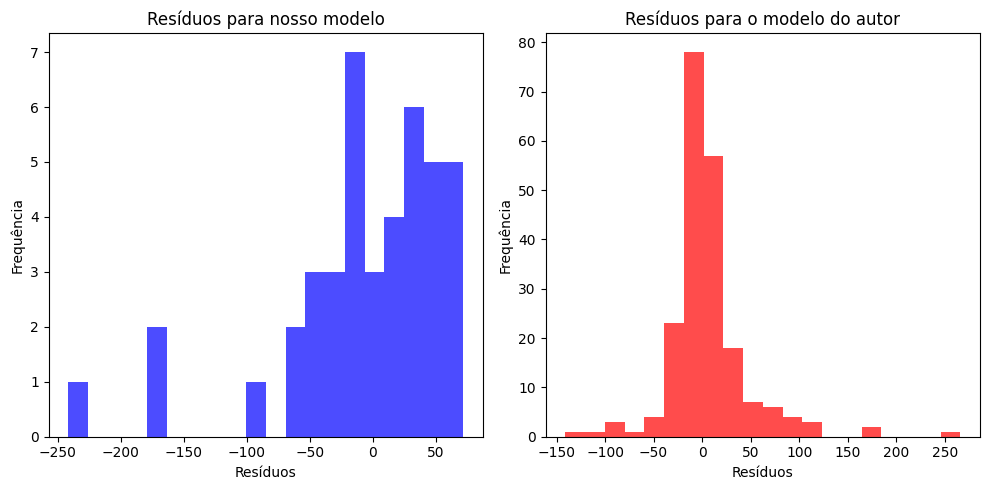

In [37]:
residues_ourmodel = y_test - y_pred_final
autor_residues = df['PRP'] - df['ERP']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(residues_ourmodel, bins=20, color='blue', alpha=0.7)
ax[0].set_title('Resíduos para nosso modelo')
ax[0].set_xlabel('Resíduos')
ax[0].set_ylabel('Frequência')

ax[1].hist(autor_residues, bins=20, color='red', alpha=0.7)
ax[1].set_title('Resíduos para o modelo do autor')
ax[1].set_xlabel('Resíduos')
ax[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [39]:
from scipy.stats import levene
print("Levene's Test Result:", levene(residues_ourmodel, autor_residues))

Levene's Test Result: LeveneResult(statistic=13.127577683500839, pvalue=0.0003526609376202329)


In [40]:
t_stat, p_value = ttest_ind(residues_ourmodel, autor_residues, equal_var=True)
print(f"T-test Result: t-statistic = {t_stat}, p-value = {p_value}")

T-test Result: t-statistic = -1.886892150804763, p-value = 0.06033817692682749


**Questão 7**: Quais são os *outliers* do seu modelo preditivo? Ou seja: para quais CPUs no conjunto de teste temos o maior erro, em valores absolutos, na direção positiva e na direção negativa do erro?

Dica: ao descobrir o índice dos outliers, retorne ao conjunto de dados original e descubra a marca e modelo da CPU.


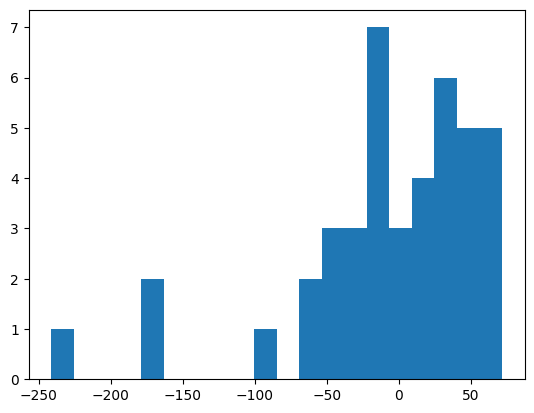

In [41]:
residues = y_test - y_pred_final

plt.hist(residues, bins=20)
plt.show()

In [42]:
abs_residues = np.abs(residues)

greatest_error_indexes = abs_residues.nlargest(3).index

df = pd.read_csv('machine.data', names=column_names)

print(df.loc[greatest_error_indexes, ['Vendor', 'Model']])

     Vendor    Model
196  sperry  1100/83
197  sperry  1100/84
195  sperry  1100/82


## Parte conceitual

**Questão 8**: Perguntei ao "ChatGPT" o seguinte: "No contexto de machine learning, explique com suas palavras e em menos de 100 palavras os conceitos de sensibilidade e especificidade.". A resposta foi:

"Sensibilidade (ou recall) e especificidade são métricas de desempenho em modelos de machine learning para classificação binária.

Sensibilidade mede a capacidade do modelo em identificar corretamente todos os casos positivos, ou seja, a proporção de verdadeiros positivos (amostras positivas classificadas corretamente) em relação ao total de casos positivos.

Especificidade, por outro lado, avalia a capacidade do modelo em identificar corretamente todos os casos negativos, ou seja, a proporção de verdadeiros negativos (amostras negativas classificadas corretamente) em relação ao total de casos negativos.

Ambas as métricas são importantes para avaliar o desempenho do modelo em diferentes contextos, dependendo das necessidades do problema em questão."

Construa um exemplo do seu cotidiano como aluno do Insper em que o trade-off sensibilidade versus especificidade poderia ser demonstrado. Você não deve incluir exemplos de projetos ou aplicativos de machine learning, ou provas academicas em geral.

Resposta:

Devido a alta demanda por aquarios no insper, os alunos de computaçao, querem criar um aplicativo que identifica se o aquario está ocupado ou não. Para isso, eles criam um modelo de machine learning que identifica se o aquario está ocupado ou não. No entanto, o modelo tem um trade-off entre sensibilidade e especificidade. Se o modelo tiver uma especificidade alta ele não vai classificar aquarios vazios como ocupados, mas pode classificar aquarios ocupados como vazios, fazendo com que os alunos percam tempo procurando um aquario cheio. Se o modelo tiver uma sensibilidade alta ele não vai classificar aquarios ocupados como vazios, mas pode classificar aquarios vazios como ocupados, fazendo com que os alunos achem que não há aquarios vazios, quando na verdade tem.

**Questão 9**: Perguntei ao "ChatGPT" o seguinte: "Explique a curva ROC para um padeiro". A resposta foi:

"Claro! Vamos adaptar a explicação da curva ROC (Receiver Operating Characteristic) para o contexto de um padeiro.

Imagine que um padeiro está tentando determinar a qualidade de duas marcas de farinha (Marca A e Marca B) para fazer seu pão. Ele quer escolher a farinha que produz o pão mais saboroso.

A curva ROC pode ser comparada à capacidade do padeiro de distinguir entre as duas marcas de farinha. Neste caso:

- Ele testa ambas as farinhas e avalia a qualidade de seus pães.
- Ele varia a quantidade de farinha de cada marca nas receitas para observar como isso afeta a qualidade do pão.
- Em seguida, ele cria uma curva ROC, onde o eixo X representa a quantidade de farinha da Marca A usada na receita e o eixo Y representa a quantidade da Marca B.
- Cada ponto na curva ROC representa uma combinação diferente de quantidades de farinha, e a curva mostra quão bem ele pode distinguir a qualidade dos pães feitos com as duas marcas.
- A área sob a curva ROC (AUC) indica o quão eficaz o padeiro é em diferenciar as farinhas; quanto maior a AUC, melhor a capacidade de escolha.

Assim, a curva ROC ajuda o padeiro a tomar uma decisão informada sobre qual farinha usar para fazer pães deliciosos com base na quantidade de cada marca em sua receita."

Ou seja, a resposta não faz o menor sentido.

Construa uma explicação melhor de curva ROC para um padeiro, que não sabe nada de *machine learning* mas sabe conduzir os negócios de uma padaria com muito sucesso.

Resposta:

Imagino que você pode precisar separar pães frescos dos pães que não estão tão frescos para vendê-los. A curva ROC consegue determinar quão bom você é em fazer essa separação.  Para determinar se um pão é fresco ou não você poode checar a maciez do pão e outros fatores mas nem sempre o teste é perfeito. Às vezes, um pão que ainda está bom pode parecer não estar (falso negativo) e, outras vezes, um pão não tão fresco pode parecer bom o suficiente para vender (falso positivo). A curva ROC ajuda a entender o quão bom é o seu teste. Ela mostra a relação entre dois fatores: A taxa de verdadeiros positivos (quando você acertadamente identifica um pão fresco) – acertar que o pão está realmente bom para venda e A taxa de falsos positivos (quando você erroneamente identifica um pão não fresco como fresco) – quando você pensa que um pão está bom, mas ele não está. No gráfico da curva ROC, quanto mais a curva se aproxima do canto superior esquerdo, melhor é o seu teste. Isso significaria que você está fazendo um ótimo trabalho ao identificar corretamente os pães frescos e não está sendo enganado pelos pães não tão frescos. Caso contrário, isso significa que você deve aprimorar o metodo de teste, para evitar que pães não frescos estejam sendo vendidos ou que pães frescos estejam sendo disperdiçados.

**Questão 10**: Construa um exemplo concreto de como o machine learning pode ajudar a aumentar a eficiência do trânsito de São Paulo. O exemplo deve ser específico de *machine learning*, e não de inteligência artificial no sentido mais amplo.

Resposta:

Um modelo de machine learning pode prever se vai ter trânsito em São Paulo com base em dados históricos de trânsito, eventos, feriados, condições climáticas e outros fatores. Com essas previsões, as pessoas podem planejar suas rotas com antecedência, evitando áreas com trânsito e reduzindo o congestionamento. Além disso, o modelo pode ser usado para otimizar os semáforos, ajustando os tempos de sinalização com base nas previsões de trânsito, para melhorar o fluxo de veículos. Ou até mesmo recomendando o uso de transporte público em vez de carro particular em dias de trânsito intenso, reduzindo o número de veículos nas ruas.